## Install requirements

In [1]:
!python.exe -m pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable


In [2]:
%pip install -r requirements-torch-windows.txt --upgrade
%pip install -r requirements.txt --upgrade

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

Looking in indexes: https://download.pytorch.org/whl/cu117
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Init stable diffusion

In [6]:
from diffusers import DiffusionPipeline
import torch

def initdiffusionpipeline(model_id):
    pipe = DiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
    pipe.to("cuda") 
    return pipe

diffusionpipeline=initdiffusionpipeline("stabilityai/stable-diffusion-xl-base-1.0")

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.06it/s]


RuntimeError: Windows not yet supported for torch.compile

In [4]:
def generate(prompt,seed=42):
    generator = torch.Generator("cuda").manual_seed(seed)
    image = diffusionpipeline(prompt,generator=generator).images[0]
    fname = f"images/{prompt.replace(' ','-')}.png"
    image.save(fname)
    display(image)
    return image

## Run

100%|██████████| 50/50 [00:16<00:00,  2.97it/s]


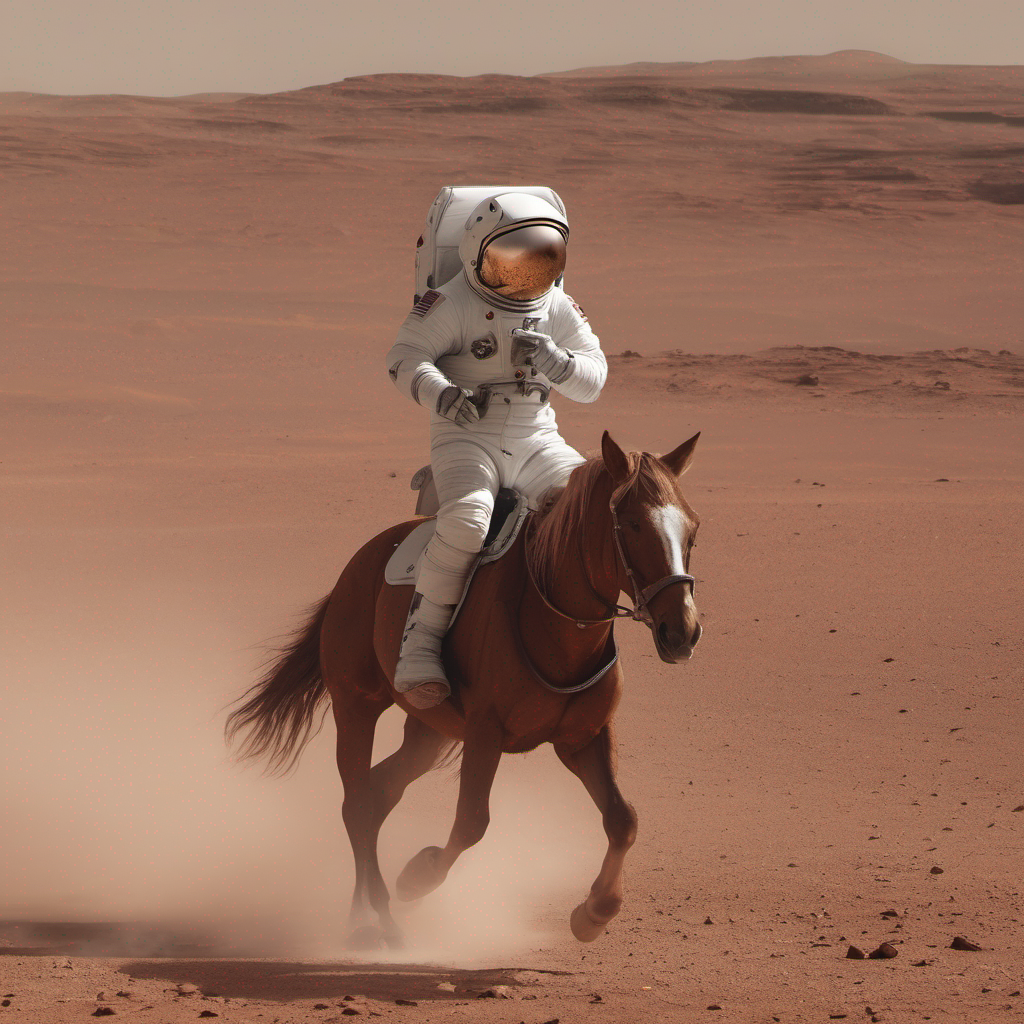

In [5]:
img=generate("a photo of an astronaut riding a horse on mars")